In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np


# 检查GPU是否可用
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [5]:
# 对 CIFAR-10 做数据增强和标准化：
# 训练集做随机裁剪、翻转和颜色扰动；测试集只做 ToTensor 和 Normalize


import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import os

# 1. 训练集：数据增强 + 标准化
train_transform = transforms.Compose(
    [
        # ---- 几何增强：旋转 / 翻转等 ----
        transforms.RandomCrop(32, padding=4),  # 模拟平移、局部视野变化
        transforms.RandomHorizontalFlip(p=0.5),  # 水平翻转
        # ---- 光照/对比度增强：对应 fundus 里亮度不均、对比度差 ----
        transforms.ColorJitter(
            brightness=0.2,  # 亮度 jitter
            contrast=0.2,  # 对比度 jitter
            saturation=0.2,  # 饱和度 jitter
            hue=0.1,  # 色调 jitter（CIFAR-10 是自然图像，可以稍微大一点）
        ),
        transforms.ToTensor(),
        # ---- 标准化：对 fundus 做 0 均值、单位方差 ----
        transforms.Normalize(
            mean=(0.4914, 0.4822, 0.4465), std=(0.2470, 0.2435, 0.2616)
        ),
    ]
)

# 2. 测试集：不做随机增强，只做 ToTensor + 标准化
test_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(
            mean=(0.4914, 0.4822, 0.4465), std=(0.2470, 0.2435, 0.2616)
        ),
    ]
)

# 3. 数据集
trainset = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=train_transform
)
testset = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=test_transform
)

# 4. DataLoader：根据 CPU 数量设置 num_workers（最多 2），避免开太多 worker 卡住。
num_workers = min(2, (os.cpu_count() or 2) // 2)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=num_workers)
testloader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=num_workers)

classes = [
    "plane",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]

print("训练样本数:", len(trainset))
print("测试样本数:", len(testset))

Files already downloaded and verified
Files already downloaded and verified
训练样本数: 50000
测试样本数: 10000


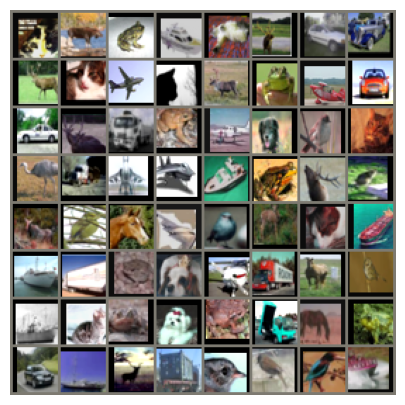

Labels: ['cat', 'deer', 'frog', 'ship', 'cat', 'deer', 'car', 'car', 'deer', 'cat', 'plane', 'cat', 'deer', 'frog', 'plane', 'car', 'car', 'deer', 'truck', 'frog', 'plane', 'dog', 'bird', 'cat', 'bird', 'truck', 'plane', 'plane', 'ship', 'frog', 'deer', 'cat', 'deer', 'bird', 'horse', 'plane', 'bird', 'deer', 'cat', 'ship', 'ship', 'truck', 'frog', 'dog', 'plane', 'truck', 'horse', 'bird', 'ship', 'cat', 'frog', 'dog', 'frog', 'truck', 'horse', 'frog', 'car', 'ship', 'deer', 'truck', 'bird', 'bird', 'bird', 'ship']


In [ ]:
# 看一眼增强后的样本，顺便检查图像和标签有没有对上

import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision

# CIFAR-10 的 mean 和 std
mean = torch.tensor([0.4914, 0.4822, 0.4465]).view(3, 1, 1)
std = torch.tensor([0.2470, 0.2435, 0.2616]).view(3, 1, 1)


def imshow(img, title=None, denorm=True):
    """img: [C,H,W] 或 [B,C,H,W] 做成 grid 后的 Tensor"""
    if denorm:
        img = img * std + mean  # 反标准化
    img = img.clamp(0.0, 1.0)

    img = img.permute(1, 2, 0).cpu().numpy()
    plt.imshow(img)
    plt.axis("off")
    if title is not None:
        plt.title(title)


# ---- 展示一批图 ----
dataiter = iter(trainloader)
images, labels = next(dataiter)

grid = torchvision.utils.make_grid(images, nrow=8)

plt.figure(figsize=(10, 5))
imshow(grid)
plt.show()

print("Labels:", [classes[l] for l in labels])

In [ ]:
# LeNet 模型，在 CIFAR-10 上做分类的简单 CNN


class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()

        # -------------------------------------------
        # 卷积特征提取部分（Feature Extraction）
        # 两层卷积 + ReLU + 池化，用于学习视觉特征
        # -------------------------------------------
        self.cnn = nn.Sequential(
            # 输入尺寸: [B, 3, 32, 32]（RGB CIFAR-10 图像）
            # Conv1: 学习边缘/纹理等低级特征
            # 卷积核 5x5, 通道 3 -> 6, 输出尺寸: [B, 6, 28, 28]
            # 右边（以及下边）有 4 个像素无法成为卷积核的下标起点
            # B是batch_size
            # ReLU折线函数来表示非线性
            nn.Conv2d(3, 6, kernel_size=5),
            nn.ReLU(),
            # Pool1 平均池化: 下采样，减少计算量
            # 输出: [B, 6, 14, 14]
            nn.AvgPool2d(2, 2),
            # Conv2: 学习更高层语义特征
            # 输出: [B, 16, 10, 10]
            nn.Conv2d(6, 16, kernel_size=5),
            nn.ReLU(),
            # Pool2 平均池化: 再次下采样，输出: [B, 16, 5, 5]
            nn.AvgPool2d(2, 2),
        )

        # -------------------------------------------
        # 全连接分类部分（Classifier）
        # 将卷积特征展平成向量并映射到 10 类（CIFAR-10）
        # -------------------------------------------
        self.fc = nn.Sequential(
            nn.Linear(16 * 5 * 5, 120),  # 400 -> 120
            nn.ReLU(),
            nn.Linear(120, 84),  # 120 -> 84
            nn.ReLU(),
            nn.Linear(84, 10),  # 84 -> 10 类
        )

        """
        前向传播 - 具体的数据流动过程
        输入 x: [B, 3, 32, 32]

        Conv1 → ReLU → Pool:
            [B, 3, 32, 32] → [B, 6, 28, 28] → [B, 6, 14, 14]

        Conv2 → ReLU → Pool:
            [B, 6, 14, 14] → [B, 16, 10, 10] → [B, 16, 5, 5]

        Flatten:
            [B, 16*5*5] = [B, 400]

        FC:
            [B, 400] → [B, 10]
        """

    def forward(self, x):
        # 卷积特征提取
        x = self.cnn(x)

        # 展平为全连接层输入：[B, 16*5*5]
        x = x.view(x.size(0), -1)

        # 分类输出（10 类 logits）
        x = self.fc(x)
        return x

In [ ]:
# 用交叉熵 + Adam 在 CIFAR-10 上训练 LeNet，并记录每个 epoch 的训练损失

# 1. 定义模型实例
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LeNet().to(device)

# 2. 定义损失函数与优化器
criterion = nn.CrossEntropyLoss()  # 多分类交叉熵

# model.parameters()这里Adam优化器保存了参数引用
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 3. 开始训练循环
num_epochs = 50
loss_history = []

for epoch in range(num_epochs):
    model.train()  # 训练模式
    running_loss = 0.0

    for images, labels in trainloader:
        images = images.to(device)
        labels = labels.to(device)

        # 1. 前向传播
        outputs = model(images)
        loss = criterion(outputs, labels)

        # 2. 反向传播前梯度清零
        optimizer.zero_grad()

        # 3. 反向传播计算梯度
        # 这里有写入参数引用
        loss.backward()

        # 4. 更新参数
        # 这里更新参数引用
        optimizer.step()

        running_loss += loss.item()
        loss_history.append(loss.item())

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(trainloader):.4f}")

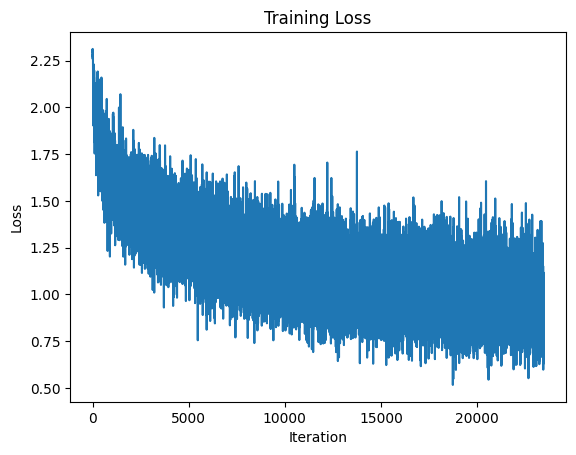

In [ ]:
# 画出训练过程中的 loss 曲线，看一下收敛情况


plt.plot(loss_history)
plt.title("Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

In [ ]:
# 在给定数据集上计算分类准确率


def evaluate(loader, model, device):
    """在给定数据加载器上评估分类准确率"""
    model.eval()  # 评估模式（关闭dropout等）
    correct = 0
    total = 0

    with torch.no_grad():  # 不记录梯度，节省显存
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)  # [B, num_classes]
            _, predicted = torch.max(outputs, 1)  # 取每行最大值的索引作为预测类别

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    acc = 100.0 * correct / total
    return acc


train_acc = evaluate(trainloader, model, device)
test_acc = evaluate(testloader, model, device)

print(f"Train Accuracy: {train_acc:.2f}%")
print(f"Test  Accuracy: {test_acc:.2f}%")

Train Accuracy: 65.86%
Test  Accuracy: 68.69%
